<span style="color:#4FA3FF; font-weight:700; font-size:120%">Optimización de Portafolios con Markowitz mediante Simulación Monte Carlo</span>

<span style="color:#4FA3FF; font-weight:700">Descripción breve:</span>

Este trabajo presenta una metodología práctica para **optimizar portafolios** utilizando el enfoque de **Markowitz** combinado con **Simulación Monte Carlo**. A partir de datos históricos obtenidos con `yfinance` se generan múltiples combinaciones de pesos para estimar el **retorno esperado**, la **volatilidad** y el **Ratio de Sharpe**.

El objetivo es identificar la **combinación más eficiente** (máximo Sharpe) y construir la **frontera eficiente** para facilitar la toma de decisiones según distintos perfiles de riesgo.

<span style="color:#4FA3FF; font-weight:700">Componentes esenciales</span>

<span style="color:#4FA3FF; font-weight:700">Datos y Preparación</span>

Se emplean ETFs y acciones reales (por ejemplo: GOOGL, NVDA, MSFT, entre otros).

Se obtienen precios históricos a través de `yfinance` y se calculan retornos diarios, que sirven como base para las simulaciones.

<span style="color:#4FA3FF; font-weight:700">Simulación Monte Carlo</span>

Se generan 100.000 (configurable) combinaciones aleatorias de pesos entre los activos. Para cada portafolio se estiman:

- **Retorno esperado**
- **Volatilidad total**
- **Ratio de Sharpe** (medida de eficiencia riesgo-rendimiento)

<span style="color:#4FA3FF; font-weight:700">Optimización</span>

Se identifica el portafolio con mayor **Sharpe Ratio**, considerado el más eficiente bajo las suposiciones del modelo.

Se construye la **frontera eficiente** y los resultados se visualizan con un gráfico de dispersión riesgo-retorno (volatilidad vs. retorno) con el Sharpe codificado por color.

<span style="color:#4FA3FF; font-weight:700">Aplicación práctica</span>

El programa permite:

- Determinar la combinación óptima de activos según la muestra histórica.
- Analizar visualmente la relación **riesgo vs rendimiento**.
- Evaluar el nivel de diversificación del portafolio.
- Ajustar decisiones según el perfil de riesgo del inversor y parámetros (p. ej. tasa libre de riesgo, número de simulaciones).

<span style="color:#4FA3FF; font-weight:700">Consideraciones</span>

- Las conclusiones dependen de datos históricos y de la ventana temporal analizada.
- Se asume una distribución aproximada de retornos (limitación del modelo).
- Los pesos en esta versión son solo positivos (sin posiciones cortas).
- Se recomienda rebalanceo periódico y validación con escenarios fuera de muestra.

(Los bloques siguientes contienen el código para descargar datos, calcular retornos, ejecutar la simulación Monte Carlo y graficar la frontera eficiente).

In [9]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Descarga los precios históricos ajustados de los activos seleccionados (maneja cambios en yfinance)
def obtener_precios_activos(activos, inicio_periodo, fin_periodo):
    marco_precios = pd.DataFrame()
    for activo in activos:
        # Solicita los datos sin modificar automáticamente los precios (auto_adjust=False)
        datos_crudos = yf.download(activo, start=inicio_periodo, end=fin_periodo, auto_adjust=False)
        # yfinance puede devolver DataFrame con columna 'Adj Close' o solo 'Close'.
        # Seleccionamos 'Adj Close' si existe, sino 'Close'. Si la respuesta es una Series, la usamos directamente.
        if isinstance(datos_crudos, pd.Series):
            serie_precios = datos_crudos
        else:
            if 'Adj Close' in datos_crudos.columns:
                serie_precios = datos_crudos['Adj Close']
            elif 'Close' in datos_crudos.columns:
                serie_precios = datos_crudos['Close']
            else:
                # Fallback: tomar la primera columna disponible
                serie_precios = datos_crudos.iloc[:, 0]
        marco_precios[activo] = serie_precios
    return marco_precios

# Definición de los activos y parámetros de consulta
acciones = ["GOOGL", "ASML", "MOH", "ORLA",
                    "NVDA", "META", "BKNG", "LEN",
                    "PFE", "KHC", "MSFT", "FLR",
                    "GRBK", "UPS", "PDD",
                    "PG", "UNH", "BIDU"]

inicio_periodo = '2019-01-01'
fin_periodo = '2025-01-01'

# Obtiene los datos históricos para los activos definidos
precios_historicos = obtener_precios_activos(acciones, inicio_periodo, fin_periodo)

precios_historicos.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

[*********************100%******

,GOOGL,ASML,MOH,ORLA,NVDA,META,BKNG,LEN,PFE,KHC,MSFT,FLR,GRBK,UPS,PDD,PG,UNH,BIDU
Date,,,,,,,,,,,,,,,,,,
2019-01-02,52.338547,145.733429,112.889999,0.795,3.377166,134.848694,1693.982056,35.530605,29.785070,30.856237,94.612602,31.620930,7.45,73.938759,22.209999,76.454628,217.128174,162.250000
2019-01-03,50.888992,137.696198,105.900002,0.872,3.173128,130.932861,1636.344971,35.166065,28.951771,30.834873,91.131981,31.073757,7.57,71.839470,21.520000,75.918579,211.207047,154.710007
2019-01-04,53.499279,143.654251,109.660004,0.872,3.376423,137.104782,1689.898804,36.642052,29.612900,31.674990,95.370476,32.753681,7.67,74.341873,22.690001,77.468102,213.677109,160.949997
2019-01-07,53.392582,146.936203,117.750000,0.875,3.555173,137.204178,1684.261108,37.682358,29.771290,32.273037,95.492119,33.512043,8.06,74.090874,23.209999,77.158188,214.087326,162.600006
2019-01-08,53.861538,145.854630,128.309998,0.875,3.466666,141.656723,1659.761963,38.135834,29.909033,32.301502,96.184502,33.876827,8.29,74.098473,24.000000,77.442993,216.949799,163.399994


In [16]:
# Calcula los retornos diarios simples de cada activo
retornos_diarios = precios_historicos.pct_change()  # Retornos porcentuales diarios

retornos_diarios.head()

,GOOGL,ASML,MOH,ORLA,NVDA,META,BKNG,LEN,PFE,KHC,MSFT,FLR,GRBK,UPS,PDD,PG,UNH,BIDU
Date,,,,,,,,,,,,,,,,,,
2019-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-03,-0.027696,-0.055150,-0.061919,0.096855,-0.060417,-0.029039,-0.034025,-0.010260,-0.027977,-0.000692,-0.036788,-0.017304,0.016107,-0.028392,-0.031067,-0.007011,-0.027270,-0.046471
2019-01-04,0.051294,0.043270,0.035505,0.000000,0.064068,0.047138,0.032728,0.041972,0.022836,0.027246,0.046509,0.054062,0.013210,0.034833,0.054368,0.020410,0.011695,0.040333
2019-01-07,-0.001994,0.022846,0.073773,0.003440,0.052941,0.000725,-0.003336,0.028391,0.005349,0.018881,0.001275,0.023153,0.050848,-0.003376,0.022918,-0.004001,0.001920,0.010252
2019-01-08,0.008783,-0.007361,0.089682,0.000000,-0.024895,0.032452,-0.014546,0.012034,0.004627,0.000882,0.007251,0.010885,0.028536,0.000103,0.034037,0.003691,0.013371,0.004920


In [17]:
# Simulación Monte Carlo para portafolios aleatorios

# Parámetros principales de la simulación
cantidad_muestras = 100000
tasa_libre_riesgo = 0.04  # Tasa libre de riesgo anual (4%)

# Inicializa los arreglos para almacenar los resultados de cada portafolio
pesos_portafolio = np.zeros((cantidad_muestras, len(simbolos_activos)))
retornos_portafolios = np.zeros(cantidad_muestras)
volatilidades_portafolios = np.zeros(cantidad_muestras)
razones_sharpe = np.zeros(cantidad_muestras)

# Ejecuta la simulación generando portafolios aleatorios
for iteracion in range(cantidad_muestras):
    # Genera pesos aleatorios y los normaliza para que sumen 1
    pesos_aleatorios = np.random.random(len(simbolos_activos))
    pesos_normalizados = pesos_aleatorios / np.sum(pesos_aleatorios)
    pesos_portafolio[iteracion, :] = pesos_normalizados
    
    # Calcula el retorno anual esperado del portafolio
    retorno_esperado = np.sum(retornos_diarios.mean() * pesos_normalizados) * 252
    retornos_portafolios[iteracion] = retorno_esperado
    
    # Calcula la volatilidad anual del portafolio
    volatilidad_esperada = np.sqrt(
        np.dot(pesos_normalizados.T, np.dot(retornos_diarios.cov() * 252, pesos_normalizados))
    )
    volatilidades_portafolios[iteracion] = volatilidad_esperada
    
    # Calcula el Ratio de Sharpe para el portafolio
    razones_sharpe[iteracion] = (retorno_esperado - tasa_libre_riesgo) / volatilidad_esperada

In [18]:
# Identifica el portafolio óptimo según el mayor Ratio de Sharpe
indice_mejor = razones_sharpe.argmax()
pesos_mejor = pesos_portafolio[indice_mejor, :]
retorno_mejor = retornos_portafolios[indice_mejor]
volatilidad_mejor = volatilidades_portafolios[indice_mejor]
sharpe_mejor = razones_sharpe[indice_mejor]

# Crea un DataFrame con los resultados de todos los portafolios simulados
resultados_simulacion = pd.DataFrame({
    'Return': retornos_portafolios,
    'Volatility': volatilidades_portafolios,
    'Sharpe Ratio': razones_sharpe
})

![Markowitz](Graficos/MarkImage.png)

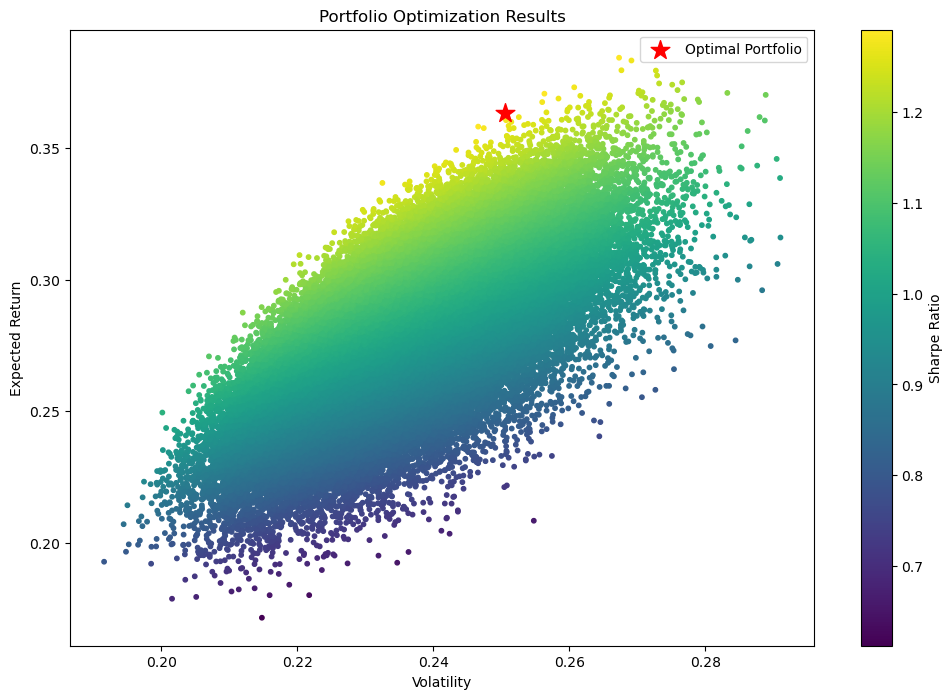


Portafolio Optimizado:
--------------------
Retorno Esperado: 36.33%
Volatilidad: 25.05%
Ratio de Sharpe: 1.29

Pesos óptimos:
GOOGL: 3.78%
ASML: 5.53%
MOH: 0.38%
ORLA: 13.20%
NVDA: 11.45%
META: 1.97%
BKNG: 1.31%
LEN: 4.95%
PFE: 2.64%
KHC: 2.41%
MSFT: 6.54%
FLR: 0.03%
GRBK: 9.38%
UPS: 7.82%
PDD: 11.08%
PG: 5.82%
UNH: 11.29%
BIDU: 0.41%


In [ ]:
# Frontera eficiente y el portafolio óptimo
plt.figure(figsize=(12,8))
plt.scatter(volatilidades_portafolios, retornos_portafolios, c=razones_sharpe, cmap='viridis', marker='o', s=10)
plt.colorbar(label='Sharpe Ratio')
plt.scatter(volatilidad_mejor, retorno_mejor, color='red', marker='*', s=200, label='Optimal Portfolio')
plt.xlabel('Volatilidad')
plt.ylabel('Retorno Esperado')
plt.title('Portafolio Optimizado')
plt.legend()
plt.show()

# Muestra los resultados del portafolio óptimo
print("\nPortafolio Optimizado:")
print("--------------------")
print(f"Retorno Esperado: {retorno_mejor*100:.2f}%")
print(f"Volatilidad: {volatilidad_mejor*100:.2f}%")
print(f"Ratio de Sharpe: {sharpe_mejor:.2f}")
print("\nPesos óptimos:")
for activo, peso in zip(simbolos_activos, pesos_mejor):
    print(f"{activo}: {peso*100:.2f}%")